<a href="https://colab.research.google.com/github/rhythmgoyal11/Momentum/blob/main/Momentum_Portfolio_Risk_using_portfolio_historical_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import gspread
from google.colab import auth
from google.auth import default

# Authenticate for Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [2]:
GOOGLE_SHEET_NAME = 'Momentum Strategy Results'
PORTFOLIO_SHEET_NAME = 'Portfolio'
PORTFOLIO_SIZE = 20

# Get Tickers and Weights from Google Sheet
try:
    print("Connecting to Google Sheet...")
    sh = gc.open(GOOGLE_SHEET_NAME)
    portfolio_ws = sh.worksheet(PORTFOLIO_SHEET_NAME)
    print(f"Successfully opened sheet: {PORTFOLIO_SHEET_NAME}")

    # Retrieve Tickers
    tickers_raw = portfolio_ws.col_values(1)[1:PORTFOLIO_SIZE+1] # Col 1 (A), Rows 2-21

    # Retrieve Weights
    weights_raw = portfolio_ws.col_values(10)[1:PORTFOLIO_SIZE+1] # Col 10 (J), Rows 2-21

    # Clean and combine data
    tickers_google_sheet = [t.strip() for t in tickers_raw]

    # Add ".NS" suffix for yfinance compatibility
    tickers = [t + '.NS' for t in tickers_google_sheet]

    weights = [float(w.strip().replace('%', '')) / 100 for w in weights_raw]

    portfolio_weights_dict = dict(zip(tickers, weights))

    # Create the final weights vector (as a numpy array)
    weights_vector = np.array(weights)

    # Check if weights sum to 1.0 and normalize if they don't
    if round(weights_vector.sum(), 4) != 1.0:
        print(f"WARNING: Weights sum to {weights_vector.sum():.4f}. Normalizing to 1.0.")
        weights_vector = weights_vector / weights_vector.sum()

    print(f"\nSuccessfully loaded {len(tickers)} tickers and weights.")
    print(f"Tickers: {tickers}")
    print(f"Weights: {weights_vector}")

except Exception as e:
    print(f"Error retrieving data from Google Sheet: {e}")
    print("Please ensure sheet names and ranges are correct.")

Connecting to Google Sheet...
Successfully opened sheet: Portfolio

Successfully loaded 20 tickers and weights.
Tickers: ['CARTRADE.NS', 'LTF.NS', 'FORCEMOT.NS', 'AIIL.NS', 'LAURUSLABS.NS', 'MUTHOOTFIN.NS', 'BLACKBUCK.NS', 'PAYTM.NS', 'SHAILY.NS', 'SYRMA.NS', 'LUMAXTECH.NS', 'V2RETAIL.NS', 'ABDL.NS', 'MAHSCOOTER.NS', 'IXIGO.NS', 'GABRIEL.NS', 'PARADEEP.NS', 'FORTIS.NS', 'RBLBANK.NS', 'IMFA.NS']
Weights: [0.06129387 0.05869413 0.02949705 0.05079492 0.05659434 0.05589441
 0.05919408 0.06929307 0.04359564 0.04459554 0.05469453 0.04759524
 0.05629437 0.02389761 0.05049495 0.05049495 0.04469553 0.04059594
 0.05179482 0.049995  ]


In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import gspread
from google.colab import auth
from google.auth import default

# Authenticate for Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)


# We will use a 6-month lookback period (approx 183 calendar days)
LOOKBACK_DAYS = 183
END_DATE = datetime.today()
START_DATE = (END_DATE - timedelta(days=LOOKBACK_DAYS)).strftime('%Y-%m-%d')
END_DATE = END_DATE.strftime('%Y-%m-%d')

print(f"\nFetching historical prices from {START_DATE} to {END_DATE}...")

# 1. Fetch Adjusted Close Prices
df_prices_raw = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)
df_prices = df_prices_raw.xs('Close', axis=1, level=0)

# 2. Clean Data
df_prices = df_prices.ffill().dropna(axis=1) # Forward fill missing data, drop any columns with no data at all
df_prices = df_prices.reindex(columns=tickers) # Ensure column order matches weight vector

# 3. Handle Mismatched Tickers
# Check if any tickers failed to download (e.g., if a ticker was delisted or changed)
if df_prices.isnull().any().any():
    missing_tickers = df_prices.columns[df_prices.isnull().all()].tolist()
    print(f"WARNING: No price data found for {missing_tickers}. These stocks will be excluded.")
    # Recalculate weights and tickers, excluding the missing ones
    weights_vector = np.array([portfolio_weights_dict[t] for t in df_prices.columns if t not in missing_tickers])
    weights_vector = weights_vector / weights_vector.sum() # Re-normalize weights
    tickers = df_prices.columns.tolist()
    df_prices = df_prices.dropna(axis=1)

print(f"Successfully downloaded price data for {len(tickers)} tickers.")


Fetching historical prices from 2025-05-16 to 2025-11-15...


/tmp/ipython-input-3506370151.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices_raw = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False)


Successfully downloaded price data for 20 tickers.


In [9]:
# Calculate Daily Returns
df_returns = np.log(df_prices / df_prices.shift(1)).dropna()

print("\n--- Sample Daily Log Returns (Head) ---")
print(df_returns.head())



--- Sample Daily Log Returns (Head) ---
Ticker      CARTRADE.NS    LTF.NS  FORCEMOT.NS   AIIL.NS  LAURUSLABS.NS  \
Date                                                                      
2025-05-19    -0.023644  0.002399    -0.031624  0.009765       0.007105   
2025-05-20     0.010977 -0.023785    -0.011133  0.022857      -0.023489   
2025-05-21     0.011220  0.013981     0.010143 -0.002614       0.006385   
2025-05-22     0.000482  0.000749    -0.008429 -0.006657      -0.010777   
2025-05-23    -0.014512  0.007970    -0.026650  0.010126       0.004476   

Ticker      MUTHOOTFIN.NS  BLACKBUCK.NS  PAYTM.NS  SHAILY.NS  SYRMA.NS  \
Date                                                                     
2025-05-19      -0.009404      0.044214  0.021587  -0.003596 -0.014645   
2025-05-20      -0.026436      0.018880 -0.023466   0.078767 -0.002974   
2025-05-21       0.028592     -0.025710 -0.009033  -0.007911  0.020729   
2025-05-22       0.003297     -0.034978 -0.017529   0.000503  0


--- Correlation Matrix Heatmap (R) ---


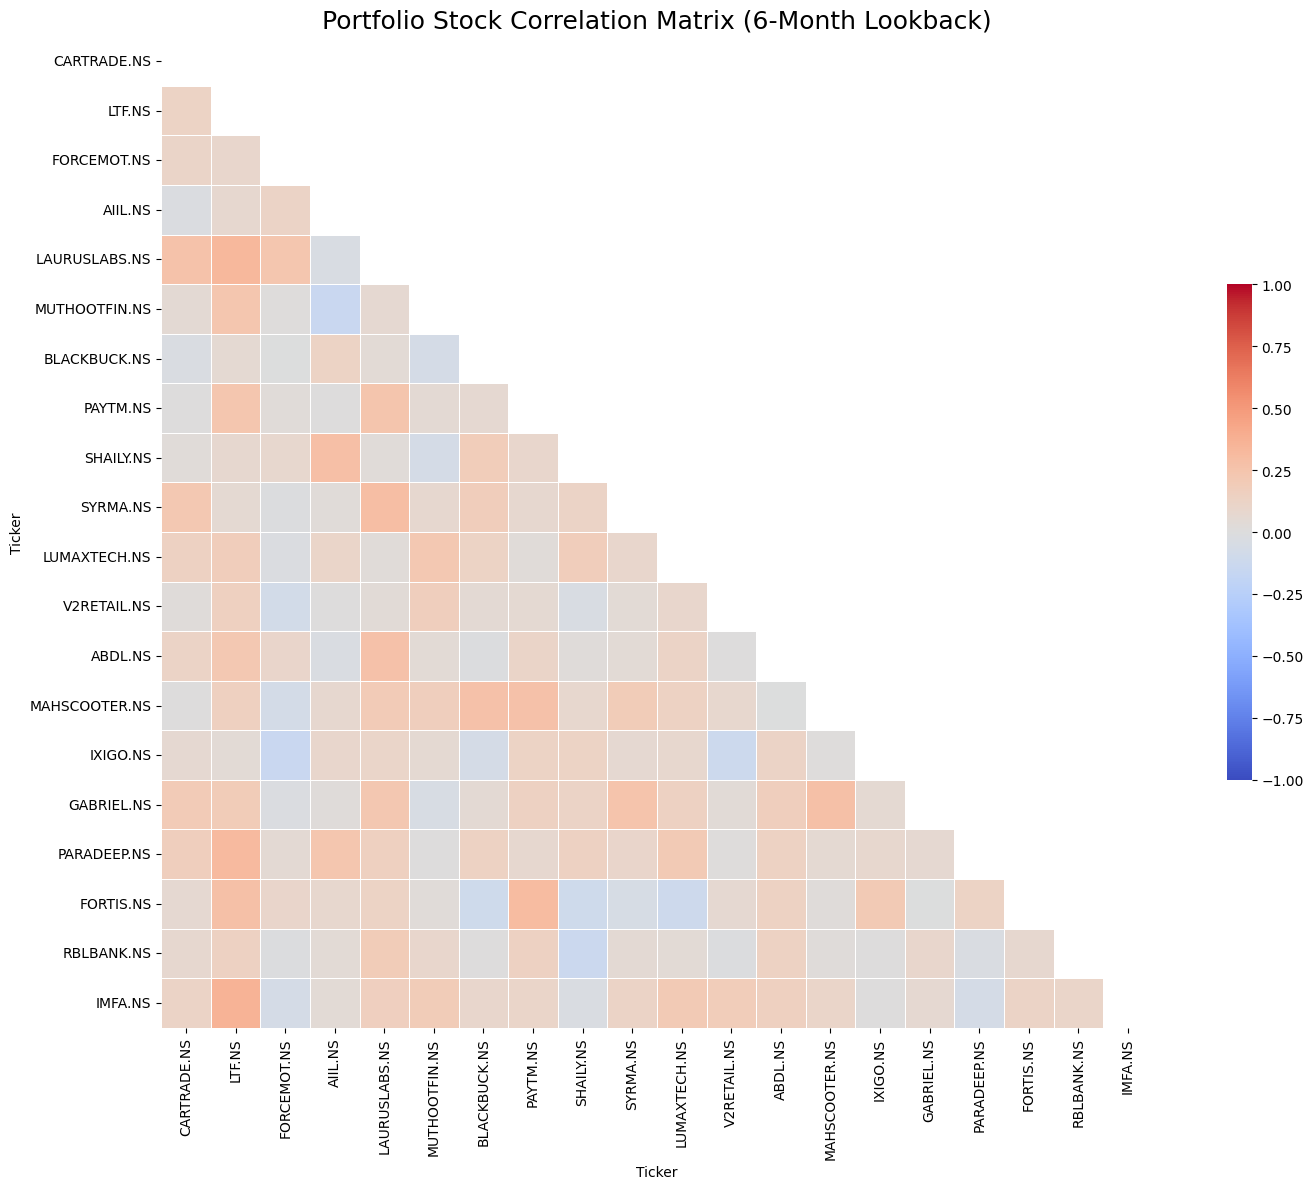


--- Annualized Covariance Matrix (Head) ---
Ticker         CARTRADE.NS    LTF.NS  FORCEMOT.NS   AIIL.NS  LAURUSLABS.NS  \
Ticker                                                                       
CARTRADE.NS       0.265087  0.019165     0.031890 -0.003585       0.036629   
LTF.NS            0.019165  0.082335     0.014239  0.007416       0.025793   
FORCEMOT.NS       0.031890  0.014239     0.300487  0.022758       0.035222   
AIIL.NS          -0.003585  0.007416     0.022758  0.117036      -0.003133   
LAURUSLABS.NS     0.036629  0.025793     0.035222 -0.003133       0.071855   

Ticker         MUTHOOTFIN.NS  BLACKBUCK.NS  PAYTM.NS  SHAILY.NS  SYRMA.NS  \
Ticker                                                                      
CARTRADE.NS         0.007934     -0.006385  0.000478   0.006699  0.041981   
LTF.NS              0.020857      0.007715  0.020751   0.010161  0.006141   
FORCEMOT.NS         0.001828     -0.001105  0.004061   0.021805 -0.001972   
AIIL.NS            -0.0

In [10]:
# Calculate Correlation/Covariance Matrices & Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the Correlation Matrix (R)
# This shows the directional relationship (from -1 to 1) between assets.
correlation_matrix = df_returns.corr()

# Calculate the Daily Covariance Matrix (Sigma)
# This measures how two assets move together, scaled by their volatility.
covariance_matrix_daily = df_returns.cov()

# Annualize the Covariance Matrix (for use in the next step)
# We multiply by 252 (approx. number of trading days in a year)
covariance_matrix_annual = covariance_matrix_daily * 252

# --- Create the Visualization ---
print("\n--- Correlation Matrix Heatmap (R) ---")

# Create a mask to hide the upper triangle (it's redundant information)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 12)) # A large figure for 20x20 stocks

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,           # Apply the mask to hide the upper half
    cmap='coolwarm',     # Use a "cool" to "warm" (Blue-White-Red) color map
    vmin=-1,             # Set the minimum of the color bar to -1
    vmax=1,             # Set the maximum of the color bar to +1
    center=0,            # Center the color map at 0 (no correlation)
    square=True,         # Ensure each cell is a square
    linewidths=.5,       # Add thin lines between cells
    cbar_kws={"shrink": .5}, # Make the color bar a bit smaller
    annot=False          # Do NOT add numbers (annot=True) - it will be unreadable with 20x20
)

plt.title('Portfolio Stock Correlation Matrix (6-Month Lookback)', fontsize=18)
plt.xticks(rotation=90, fontsize=10) # Rotate x-axis labels for readability
plt.yticks(rotation=0, fontsize=10)  # Keep y-axis labels horizontal
plt.tight_layout() # Fit the plot neatly
plt.show()


# --- Print Covariance Matrix Head (for use in next step) ---
print("\n--- Annualized Covariance Matrix (Head) ---")
print(covariance_matrix_annual.head())

In [11]:
# 5. Implement Multi-Asset Portfolio Standard Deviation Formula

# Ensure the covariance matrix columns/index are in the *exact* same order as the weights vector
# This is crucial because Cell 3 already re-ordered 'tickers' if data was missing
covariance_matrix_aligned = covariance_matrix_annual.reindex(columns=tickers, index=tickers).values

# Formula: Portfolio Variance = w^T * Sigma * w
# (w_transpose @ covariance_matrix @ w)
portfolio_variance_annual = weights_vector.T @ covariance_matrix_aligned @ weights_vector

# Portfolio Standard Deviation (Risk) is the square root of the variance
portfolio_std_dev_annual = np.sqrt(portfolio_variance_annual)

print("\n--- Portfolio Risk Results ---")
print(f"Portfolio Variance (Annualized): {portfolio_variance_annual:.6f}")
print(f"Portfolio Standard Deviation (Annualized): {portfolio_std_dev_annual:.4f} (or {portfolio_std_dev_annual:.2%})")


--- Portfolio Risk Results ---
Portfolio Variance (Annualized): 0.022722
Portfolio Standard Deviation (Annualized): 0.1507 (or 15.07%)


In [12]:
# Contextual Metrics(*Extras*)

# Calculate individual asset annualized standard deviation (volatility)
individual_volatility = df_returns.std() * np.sqrt(252)
print("\n--- Individual Stock Volatility (Annualized) ---")
# Sort by volatility to see the riskiest stocks in your portfolio
print(individual_volatility.sort_values(ascending=False))

# Calculate Expected Portfolio Return (based on historical average)
# 1. Get annualized mean return for each stock
annual_returns = df_returns.mean() * 252

# 2. Calculate the weighted average of individual returns (dot product)
# We use the 'tickers' list which was cleaned in Cell 3
expected_portfolio_return = np.dot(annual_returns.reindex(tickers).values, weights_vector)

print(f"\nExpected Portfolio Return (Annualized): {expected_portfolio_return:.4f} (or {expected_portfolio_return:.2%})")

# 3. Calculate Portfolio Sharpe Ratio (Risk-Adjusted Return)
# Assuming a 5.5% risk-free rate - Adjust as needed, this is the latest repo rate in India as of November 2025
RISK_FREE_RATE = 0.055
sharpe_ratio = (expected_portfolio_return - RISK_FREE_RATE) / portfolio_std_dev_annual

print(f"Portfolio Sharpe Ratio (Historical): {sharpe_ratio:.4f}")


--- Individual Stock Volatility (Annualized) ---
Ticker
LUMAXTECH.NS     0.594554
IXIGO.NS         0.586883
FORCEMOT.NS      0.548167
GABRIEL.NS       0.535005
CARTRADE.NS      0.514866
PARADEEP.NS      0.484607
SHAILY.NS        0.469336
BLACKBUCK.NS     0.459024
IMFA.NS          0.441951
V2RETAIL.NS      0.415621
ABDL.NS          0.365219
SYRMA.NS         0.362008
MAHSCOOTER.NS    0.355743
AIIL.NS          0.342105
RBLBANK.NS       0.325866
PAYTM.NS         0.302467
MUTHOOTFIN.NS    0.300879
LTF.NS           0.286940
FORTIS.NS        0.268707
LAURUSLABS.NS    0.268059
dtype: float64

Expected Portfolio Return (Annualized): 0.9544 (or 95.44%)
Portfolio Sharpe Ratio (Historical): 5.9669


In [13]:
# Export Risk Metric to Google Sheet

# Example: Update cell C38 (Row 38, Col 3) with the portfolio std dev
try:
    portfolio_ws.update_cell(40, 8, f"{portfolio_std_dev_annual:.2%}")
    print(f"\nSuccessfully updated 'Portfolio!H40' with Annualized Standard Deviation: {portfolio_std_dev_annual:.2%}")
except Exception as e:
    print(f"\nCould not update Google Sheet. Error: {e}")


Successfully updated 'Portfolio!H40' with Annualized Standard Deviation: 15.07%
